# Imports

In [82]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.sql.functions import *
from pyspark.mllib.evaluation import MulticlassMetrics
import pyspark.sql.functions as F
from pyspark.ml.classification import LinearSVC



In [83]:
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable


In [84]:
%pip install sparkxgb
# Pour XGBoost

from sparkxgb.xgboost import XGBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [85]:
!pip install findspark

Defaulting to user installation because normal site-packages is not writeable


In [86]:
import findspark
findspark.init()
import os

# Create temp directory for Spark
temp_dir = os.path.join(os.getcwd(), "spark_temp")
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)


# Starting sparrk Session

In [87]:
# Then modify your Spark session configuration to include XGBoost
spark = SparkSession.builder \
    .appName("TweetClassification") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "4") \
    .config("spark.local.dir", temp_dir) \
    .config("spark.jars.packages", "ml.dmlc:xgboost4j-spark_2.12:1.7.1,ml.dmlc:xgboost4j_2.12:1.7.1") \
    .getOrCreate()

In [88]:
# 1. IDENTIFICATION ET COLLECTE DES DONNÉES
print("1. Chargement et analyse initiale des données")
print("-" * 50)


1. Chargement et analyse initiale des données
--------------------------------------------------


In [89]:
# Chargement des données
train_df = spark.read.csv('../data/train_tweets.csv', header=True)
test_df = spark.read.csv('../data/test_tweets.csv', header=True)

In [90]:
# Analyse exploratoire des données
print("Aperçu du jeu de données:")
train_df.show(5)
print("\nSchéma des données:")
train_df.printSchema()


Aperçu du jeu de données:
+------------------+--------+--------------------+
|           TweetId|   Label|           TweetText|
+------------------+--------+--------------------+
|304271250237304833|Politics|'#SecKerry: The v...|
|304834304222064640|Politics|'@rraina1481 I fe...|
|303568995880144898|  Sports|'Watch video high...|
|304366580664528896|  Sports|'RT @chelscanlan:...|
|296770931098009601|  Sports|'@cricketfox Alwa...|
+------------------+--------+--------------------+
only showing top 5 rows


Schéma des données:
root
 |-- TweetId: string (nullable = true)
 |-- Label: string (nullable = true)
 |-- TweetText: string (nullable = true)



In [91]:
# Statistiques descriptives
print("\nStatistiques des données:")
print(f"Nombre total d'échantillons: {train_df.count()}")


Statistiques des données:
Nombre total d'échantillons: 6525


In [92]:
print("\nDistribution des classes:")
train_df.groupBy("Label").count().show()


Distribution des classes:
+--------+-----+
|   Label|count|
+--------+-----+
|Politics| 3200|
|  Sports| 3325|
+--------+-----+



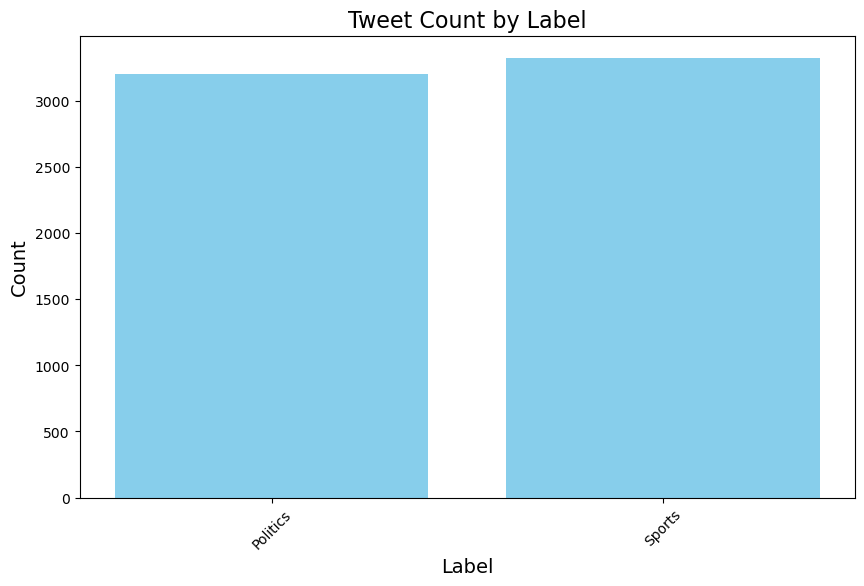

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

label_counts = train_df.groupBy("Label").count().toPandas()

plt.figure(figsize=(10, 6))
plt.bar(label_counts["Label"], label_counts["count"], color='skyblue')
plt.title("Tweet Count by Label", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.show()


Well balanced Dataset

In [94]:
# Vérification des valeurs manquantes
print("\nVérification des valeurs manquantes:")
for column in train_df.columns:
    null_count = train_df.filter(col(column).isNull()).count()
    print(f"{column}: {null_count} valeurs manquantes")


Vérification des valeurs manquantes:
TweetId: 0 valeurs manquantes
Label: 0 valeurs manquantes
TweetText: 0 valeurs manquantes


No futher processing is necessary

In [95]:
def word_count_spark(data):
    freqs = {}
    rows = data.collect()
    
    for row in rows:
        label = row['Label']
        tweet_text = row['TweetText']
        
        for word in tweet_text.split():  
            pair = (word, label)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
                
    return freqs

word_count_dict = word_count_spark(train_df)

In [96]:
word_count_dict

{("'#SecKerry:", 'Politics'): 21,
 ('The', 'Politics'): 173,
 ('value', 'Politics'): 6,
 ('of', 'Politics'): 1249,
 ('the', 'Politics'): 1833,
 ('@StateDept', 'Politics'): 5,
 ('and', 'Politics'): 648,
 ('@USAID', 'Politics'): 2,
 ('is', 'Politics'): 404,
 ('measured,', 'Politics'): 1,
 ('not', 'Politics'): 105,
 ('in', 'Politics'): 955,
 ('dollars,', 'Politics'): 1,
 ('but', 'Politics'): 55,
 ('terms', 'Politics'): 3,
 ('our', 'Politics'): 199,
 ('deepest', 'Politics'): 1,
 ('American', 'Politics'): 31,
 ("values.'", 'Politics'): 1,
 ("'@rraina1481", 'Politics'): 4,
 ('I', 'Politics'): 103,
 ('fear', 'Politics'): 4,
 ("so'", 'Politics'): 1,
 ("'Watch", 'Sports'): 13,
 ('video', 'Sports'): 17,
 ('highlights', 'Sports'): 19,
 ('of', 'Sports'): 626,
 ('the', 'Sports'): 1923,
 ('#wwc13', 'Sports'): 17,
 ('final', 'Sports'): 75,
 ('between', 'Sports'): 34,
 ('Australia', 'Sports'): 62,
 ('and', 'Sports'): 545,
 ('West', 'Sports'): 22,
 ('Indies', 'Sports'): 12,
 ('at', 'Sports'): 408,
 ("h

This gave us an idea to understand more the distribution of our data and the effect of single words on the potential label

In [97]:
# 2. PRÉTRAITEMENT DES DONNÉES
print("\n2. Prétraitement des données")
print("-" * 50)


2. Prétraitement des données
--------------------------------------------------


In [98]:
# Nettoyage du texte
def clean_text(df):
    return df.withColumn("cleaned_text", 
        regexp_replace(lower(col("TweetText")), "[^a-zA-Z\\s]", " "))

In [99]:
train_df = clean_text(train_df)

In [100]:
# Pipeline de prétraitement
# 1. Conversion des labels en indices
labelIndexer = StringIndexer(inputCol="Label", outputCol="label")

In [101]:
# 2. Tokenization
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="words")

In [102]:
# 3. Suppression des stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

In [103]:
df = pd.DataFrame(list(word_count_dict.items()), columns=['Word_Label', 'count'])

In [104]:
import nltk
from nltk.corpus import stopwords
df[['word', 'label']] = pd.DataFrame(df['Word_Label'].tolist(), index=df.index)
df.drop(columns=['Word_Label'], inplace=True)
# Load the English stopwords list from NLTK
stop_words = set(stopwords.words('english'))

# Filter out stopwords from the DataFrame
df = df[~df['word'].isin(stop_words)]
top_words_df = df.sort_values(['label', 'count'], ascending=[True, False])

In [105]:
top_words_df = top_words_df.groupby('label').head(5)
print(top_words_df)

     count                    word     label
930    405                   &amp;  Politics
545    258                     'RT  Politics
172    238                       -  Politics
173    208               President  Politics
1      173                     The  Politics
37     355                     'RT    Sports
219    217                       -    Sports
105    213                #IndvAus    Sports
90     206                   Test.    Sports
106    198  http://t.co/fVNl1KTPB1    Sports


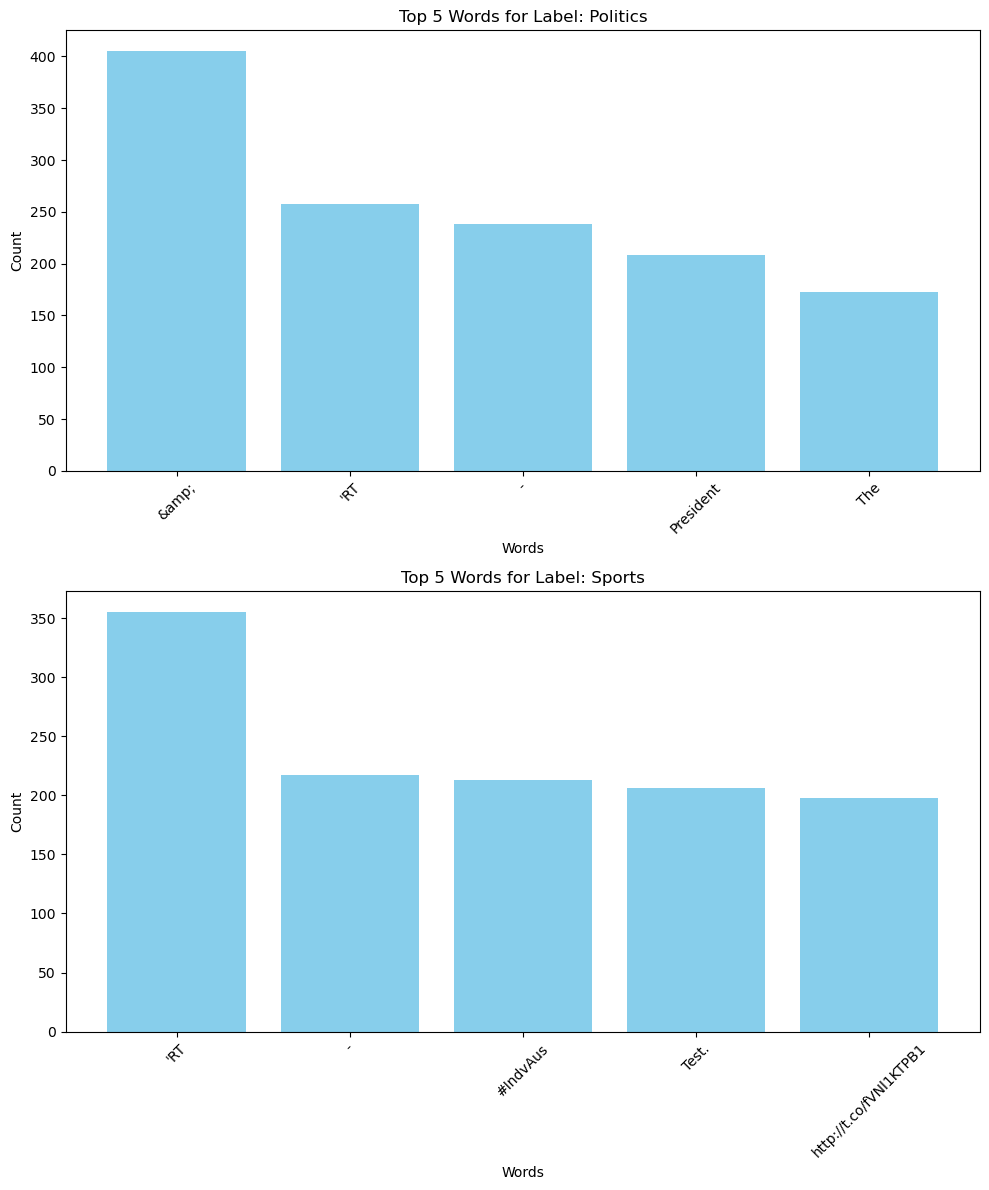

In [106]:
labels = top_words_df['label'].unique()
fig, axes = plt.subplots(len(labels), 1, figsize=(10, 6 * len(labels)))
for i, label in enumerate(labels):
    label_df = top_words_df[top_words_df['label'] == label]
    axes[i].bar(label_df['word'], label_df['count'], color='skyblue')
    axes[i].set_xlabel('Words')
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'Top 5 Words for Label: {label}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [107]:
# 4. Vectorisation TF
countVectorizer = CountVectorizer(inputCol="filtered_words", outputCol="tf", minDF=2.0)

In [108]:
# 5. IDF
idf = IDF(inputCol="tf", outputCol="features")

In [109]:
# Création du pipeline
preprocessing_pipeline = Pipeline(stages=[
    labelIndexer,
    tokenizer,
    remover,
    countVectorizer,
    idf
])

In [110]:
# Division des données
train_data, val_data = train_df.randomSplit([0.8, 0.2], seed=42)

In [111]:
# Application du pipeline
pipeline_model = preprocessing_pipeline.fit(train_data)
train_processed = pipeline_model.transform(train_data)
val_processed = pipeline_model.transform(val_data)

In [112]:
# 3. DÉVELOPPEMENT DES MÉTHODES D'APPRENTISSAGE
print("\n3. Entraînement des modèles")
print("-" * 50)


3. Entraînement des modèles
--------------------------------------------------


In [113]:
# Logistic Regression
lr = LogisticRegression(maxIter=20)
lr_model = lr.fit(train_processed)

In [114]:
# Random Forest
rf = RandomForestClassifier(numTrees=10)
rf_model = rf.fit(train_processed)

In [115]:
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [116]:
# XGBoost
xgb = XGBoostClassifier(
    numRound=100,
    featuresCol="features",
    labelCol="label", 
    missing=0.0
)
xgb_model = xgb.fit(train_processed)

In [117]:
# Support Vector Machine
svm = LinearSVC(maxIter=10, 
                regParam=0.1,
                featuresCol="features",
                labelCol="label")
svm_model = svm.fit(train_processed)

In [118]:
# 4. ÉVALUATION DES PERFORMANCES
print("\n4. Évaluation des performances")
print("-" * 50)


4. Évaluation des performances
--------------------------------------------------


In [119]:
from sklearn.metrics import confusion_matrix


def evaluate_model(model, data, model_name):
    predictions = model.transform(data)
    
    # Métriques de classification
    evaluator_acc = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="accuracy"
    )
    
    evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="f1"
    )
    
    evaluator_precision = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedPrecision"
    )
    
    evaluator_recall = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedRecall"
    )
    
    accuracy = evaluator_acc.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)
    
    print(f"\nRésultats pour {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    # Matrice de confusion
    predictions_pd = predictions.select("label", "prediction").toPandas()
    conf_matrix = confusion_matrix(predictions_pd["label"], predictions_pd["prediction"])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de confusion - {model_name}')
    plt.ylabel('Vraie classe')
    plt.xlabel('Prédiction')
    plt.show()
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [120]:
# Évaluation des modèles
results = []


Résultats pour Logistic Regression:
Accuracy: 0.9181
F1-Score: 0.9181
Precision: 0.9181
Recall: 0.9181


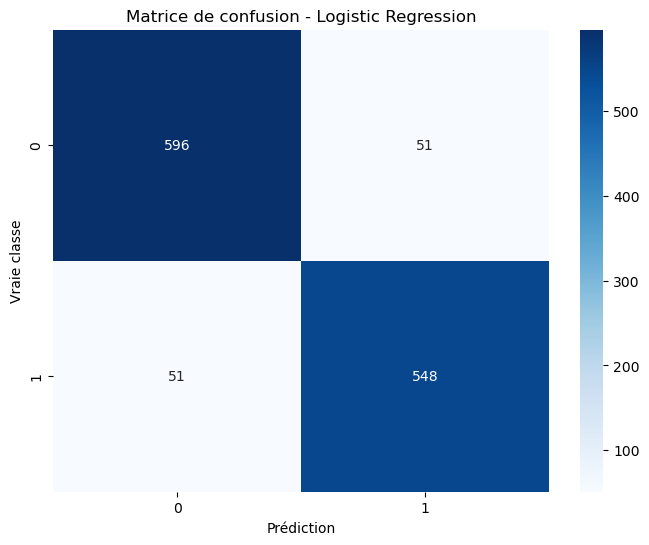


Résultats pour Random Forest:
Accuracy: 0.7456
F1-Score: 0.7456
Precision: 0.7456
Recall: 0.7456


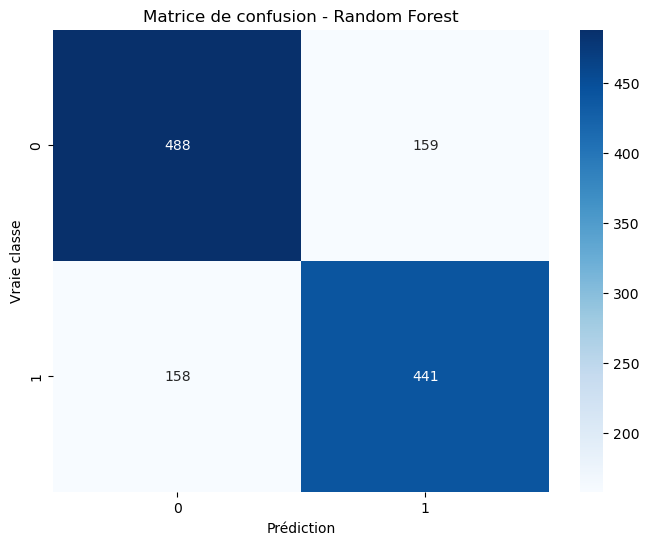


Résultats pour XGBoost:
Accuracy: 0.8965
F1-Score: 0.8963
Precision: 0.8971
Recall: 0.8965


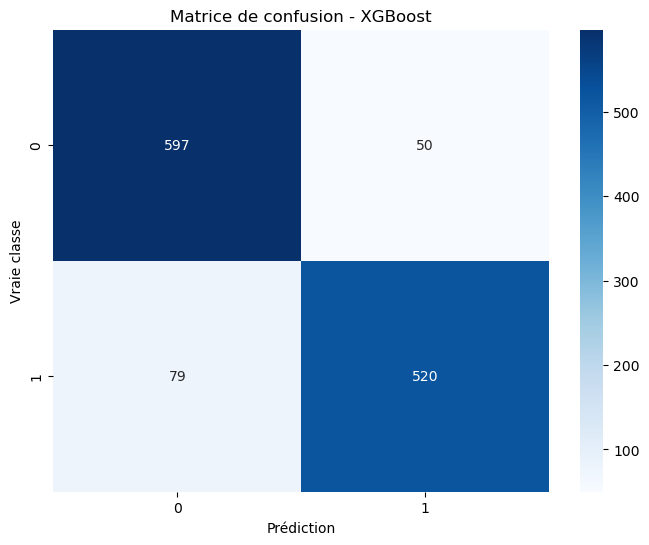


Résultats pour Support Vector Machine:
Accuracy: 0.9446
F1-Score: 0.9446
Precision: 0.9448
Recall: 0.9446


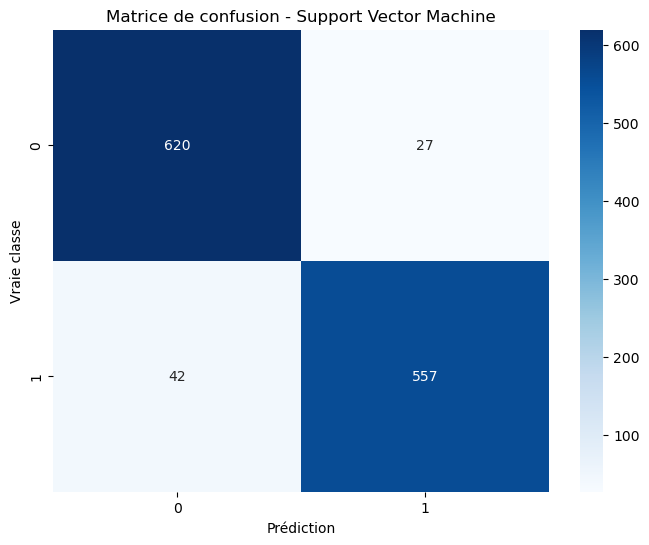

In [121]:
results.append(evaluate_model(lr_model, val_processed, "Logistic Regression"))
results.append(evaluate_model(rf_model, val_processed, "Random Forest"))
results.append(evaluate_model(xgb_model, val_processed, "XGBoost"))
results.append(evaluate_model(svm_model, val_processed, "Support Vector Machine"))


In [122]:
import pandas as pd

# Comparaison des modèles
results_df = pd.DataFrame(results)
metrics = ['accuracy', 'f1', 'precision', 'recall']

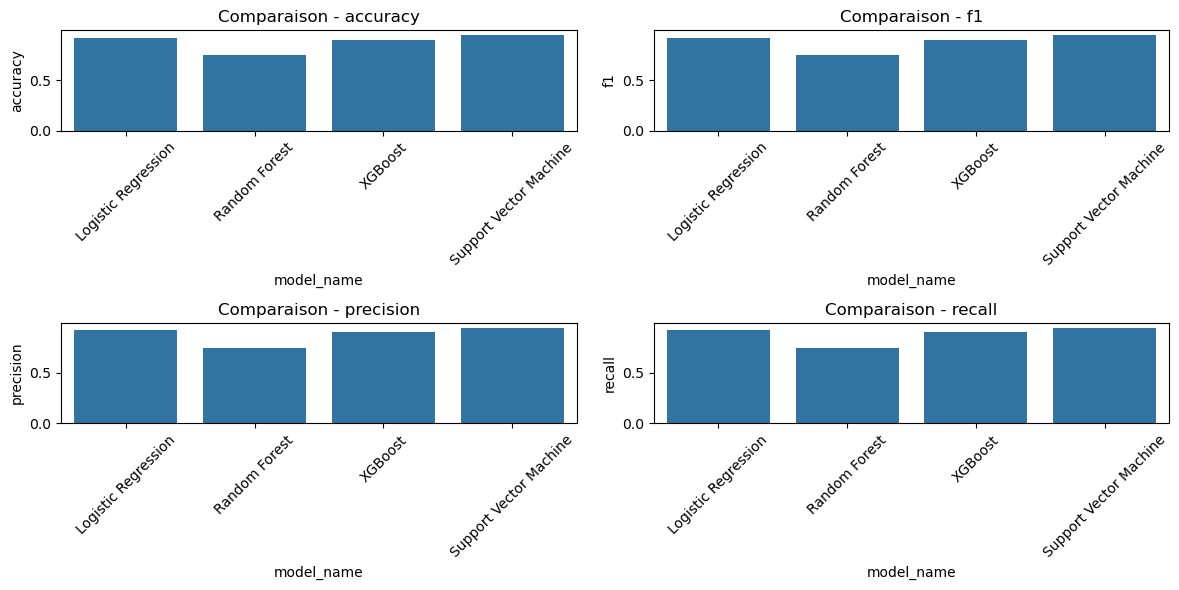

In [123]:
plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='model_name', y=metric, data=results_df)
    plt.title(f'Comparaison - {metric}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [124]:
# Sélection du meilleur modèle
best_model = results_df.loc[results_df['f1'].idxmax()]
print("\nMeilleur modèle:")
print(f"Modèle: {best_model['model_name']}")
print(f"F1-Score: {best_model['f1']:.4f}")



Meilleur modèle:
Modèle: Support Vector Machine
F1-Score: 0.9446
